<a href="https://colab.research.google.com/github/djhshih/rxrx-covid/blob/main/explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 # Background

Our high throughput screening team conducts experiments where we image cells in 1536-well plates.  Cells isolated in each well are exposed to a specific set of conditions.   In this dataset, we have exposed human renal cortical epithelial cells (HRCE) and African green monkey kidney epithelial cells (Vero) to active and UV-inactivated Covid19 virus.  For each well in the plate, we image 4 tiled locations (which may overlap), referred to as sites.  Once the images are collected, we transform them into embeddings using our own internal deep learning model.  This effectively reduces the information content of each image into 1024 features which can be used to perform your analysis.

To summarize, we have:
- two cell types (HRCE and Vero)
- four independent experiments (two per cell type), each consisting of multiple plates
- 1536 wells per plate
- 2 disease condiations:  active or UV-inactivated Covid19 virus
- 4 sites imaged per well
- embeddings (i.e. features) for each site image

# Objective

Above we've described a **heterogeneous data set** obtained from multiple cell types and experiments that we expect to be systematically different from one another in our feature space due to both intrinsic and environmental factors. We ultimately want to be able to use this data to build a single model that distinguishes between healthy and diseased cells, and that is broadly applicable to new data for either cell type. **Your objective here is to normalize, combine and otherwise prepare this data to be used in a single modeling task, including the creation of a simple train/test split.**  

You may assume that any new data obtained will include a set of disease and healthy controls (in addition to wells of unknown condition, which your model will score).


<img src="https://www.brookslifesciences.com/sites/default/files/products/4titude/plates-microplates/pcr-plates/4ti-1384-384-well-skirted-pcr-plate/carousel/4ti-1384_front.jpg">

# Solution
## Imports

In [3]:
!pip install combat

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pl
import sklearn as sk
import numpy as np
from combat.pycombat import pycombat
from plotnine import *
from sklearn.decomposition import PCA
import random

## Read in Data

In [5]:
sample_data = pd.read_csv('https://storage.googleapis.com/rxrx-sample-data/sample_data.csv')
metadata_cols = ['site_id', 'well_id', 'cell_type', 'experiment', 'plate', 'well', 'site', 'disease_condition']
sample_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
sample_data.columns

Index(['site_id', 'well_id', 'cell_type', 'experiment', 'plate', 'well',
       'site', 'disease_condition', 'feature_0', 'feature_1',
       ...
       'feature_1014', 'feature_1015', 'feature_1016', 'feature_1017',
       'feature_1018', 'feature_1019', 'feature_1020', 'feature_1021',
       'feature_1022', 'feature_1023'],
      dtype='object', length=1032)

In [7]:
sample_data.describe()

,plate,site,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,...,feature_984,feature_985,feature_986,feature_987,feature_988,feature_989,feature_990,feature_991,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999,feature_1000,feature_1001,feature_1002,feature_1003,feature_1004,feature_1005,feature_1006,feature_1007,feature_1008,feature_1009,feature_1010,feature_1011,feature_1012,feature_1013,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
count,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,...,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000,26312.000000
mean,12.844634,2.500000,2.006144,-0.007130,-0.451248,-0.049758,-0.677963,0.551251,0.165530,-0.070577,0.070436,-0.175402,-2.541335,-0.132439,-0.256584,0.793785,-0.252368,-0.949316,-0.264909,-0.142251,0.214623,0.049071,-0.644955,-0.221116,0.505040,0.224434,-1.985584,0.599012,0.118944,-1.150649,0.707777,0.985953,0.605137,0.094257,-0.991570,0.393126,-1.440203,0.072919,-1.498454,0.558372,...,0.920067,-0.791063,0.375665,-0.047665,0.090027,-0.055695,-0.067439,0.156160,-0.551505,-0.124293,-0.375578,-0.390448,0.097722,0.530397,0.264748,-0.245744,0.730846,0.694701,0.814199,-0.122457,0.750908,0.173155,-1.023660,-0.106504,-0.523126,0.560327,0.051051,0.199041,-1.232846,0.668924,0.563596,0.998113,-0.999028,-1.049231,-1.335464,-0.010090,-0.057984,0.397072,-0.320275,-1.531284
std,8.781688,1.118055,0.733912,0.293988,0.554078,0.440601,0.340155,0.300528,0.296025,0.392564,0.374205,0.453187,0.347806,0.617861,0.311593,0.423988,0.609381,0.482459,0.340343,0.335198,0.309368,0.335103,0.288979,0.437354,0.268078,0.322705,0.723451,0.345902,0.259892,0.325183,0.523082,0.343082,0.393108,0.295967,0.453535,0.365482,0.416136,0.343478,0.313846,0.264721,...,0.801358,0.450627,0.366960,0.286955,0.498410,0.215207,0.395975,0.388226,0.658657,0.567170,0.377651,0.328811,0.328132,0.283102,0.407173,0.565947,0.500454,0.380655,0.366373,0.279383,0.408847,0.334873,0.280114,0.318341,0.244193,0.475792,0.292999,0.436913,0.847468,0.443596,0.454366,0.390222,0.548680,0.338161,0.268669,0.347330,0.793472,0.586613,0.388031,0.484943
min,1.000000,1.000000,-0.702054,-1.343151,-2.586355,-2.256134,-2.569241,-0.958506,-1.251047,-1.705803,-1.351382,-1.496003,-3.727609,-2.329289,-1.518614,-1.134961,-1.708025,-2.305897,-1.522900,-1.672307,-1.934968,-1.478646,-2.211837,-2.226718,-0.831368,-2.077892,-3.325991,-0.894880,-0.970216,-2.263688,-1.727088,-0.643738,-1.030369,-0.965405,-2.118976,-1.182312,-2.618017,-1.088952,-2.561663,-0.734850,...,-1.975347,-2.887455,-1.554958,-1.331940,-1.654591,-1.235531,-2.029869,-1.577396,-1.752023,-2.010747,-1.577913,-2.0138

In [8]:
sample_data.experiment

0        HRCE-1
1        HRCE-1
2        HRCE-1
3        HRCE-1
4        HRCE-1
          ...  
26307    VERO-2
26308    VERO-2
26309    VERO-2
26310    VERO-2
26311    VERO-2
Name: experiment, Length: 26312, dtype: object

In [9]:
sample_data.cell_type

0        HRCE
1        HRCE
2        HRCE
3        HRCE
4        HRCE
         ... 
26307    VERO
26308    VERO
26309    VERO
26310    VERO
26311    VERO
Name: cell_type, Length: 26312, dtype: object

In [10]:
sample_data.disease_condition

0        UV Inactivated SARS-CoV-2
1        UV Inactivated SARS-CoV-2
2        UV Inactivated SARS-CoV-2
3        UV Inactivated SARS-CoV-2
4        UV Inactivated SARS-CoV-2
                   ...            
26307            Active SARS-CoV-2
26308            Active SARS-CoV-2
26309            Active SARS-CoV-2
26310            Active SARS-CoV-2
26311            Active SARS-CoV-2
Name: disease_condition, Length: 26312, dtype: object

In [11]:
idx = np.where(sample_data.columns == 'feature_0')
features = sample_data.iloc[:, 8:]
features.head()
features.shape

(26312, 1024)

In [12]:
pheno = sample_data.iloc[:, :8]
pheno

,site_id,well_id,cell_type,experiment,plate,well,site,disease_condition
0,HRCE-1_1_AA08_1,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,1,UV Inactivated SARS-CoV-2
1,HRCE-1_1_AA08_2,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,2,UV Inactivated SARS-CoV-2
2,HRCE-1_1_AA08_3,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,3,UV Inactivated SARS-CoV-2
3,HRCE-1_1_AA08_4,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,4,UV Inactivated SARS-CoV-2
4,HRCE-1_1_AA16_1,HRCE-1_1_AA16,HRCE,HRCE-1,1,AA16,1,UV Inactivated SARS-CoV-2
...,...,...,...,...,...,...,...,...
26307,VERO-2_2_Z43_4,VERO-2_2_Z43,VERO,VERO-2,2,Z43,4,Active SARS-CoV-2
26308,VERO-2_2_Z47_1,VERO-2_2_Z47,VERO,VERO-2,2,Z47,1,Active SARS-CoV-2
26309,VERO-2_2_Z47_2,VERO-2_2_Z47,VERO,VERO-2,2,Z47,2,Active SARS-CoV-2
26310,VERO-2_2_Z47_3,VERO-2_2_Z47,VERO,VERO-2,2,Z47,3,Active SARS-CoV-2


In [13]:
pca = PCA()
pca.fit(features.T)

PCA()

In [14]:
pca.components_.shape

(1024, 26312)

In [15]:
df = pd.concat(
  [ pheno, pd.DataFrame(pca.components_.T, columns=['pc' + str(i+1) for i in range(pca.n_components_)]) ],
  axis = 1
)
df

,site_id,well_id,cell_type,experiment,plate,well,site,disease_condition,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,...,pc985,pc986,pc987,pc988,pc989,pc990,pc991,pc992,pc993,pc994,pc995,pc996,pc997,pc998,pc999,pc1000,pc1001,pc1002,pc1003,pc1004,pc1005,pc1006,pc1007,pc1008,pc1009,pc1010,pc1011,pc1012,pc1013,pc1014,pc1015,pc1016,pc1017,pc1018,pc1019,pc1020,pc1021,pc1022,pc1023,pc1024
0,HRCE-1_1_AA08_1,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,1,UV Inactivated SARS-CoV-2,-0.006849,0.001991,0.003646,0.007557,0.000373,-0.001203,-0.001668,-0.001027,-0.000439,0.011353,-0.004829,0.003825,-0.000587,0.007281,0.003539,0.008433,0.003857,0.016206,0.001872,0.003443,0.015657,0.006725,-0.002609,-0.001131,-0.000387,0.002827,-0.010484,-0.008973,0.002357,-0.003732,-0.000388,-0.009427,...,-0.003808,-0.008091,-0.004252,-0.001590,0.001231,-0.003530,0.000740,-0.002408,0.001851,-0.001233,0.000069,7.551632e-03,0.003149,-0.003636,0.004011,-0.000516,-0.002872,0.003233,-0.000897,0.002354,0.004352,0.000706,-0.005337,0.006135,-0.000310,0.003892,0.002161,0.003296,0.005447,0.013539,-0.003280,0.000842,-0.007266,0.001255,0.002737,-0.001815,0.001393,0.013252,-0.003048,-0.163540
1,HRCE-1_1_AA08_2,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,2,UV Inactivated SARS-CoV-2,-0.006404,0.002396,0.005300,0.008003,0.000490,0.002880,-0.001863,-0.000383,-0.006219,0.006979,-0.012650,0.006297,-0.008451,0.002301,-0.003795,0.011217,-0.012390,0.013207,0.004007,0.005262,0.008069,0.000166,-0.003155,0.001624,0.001710,-0.008373,-0.000850,-0.008444,-0.000054,-0.003906,-0.001533,0.004771,...,-0.008255,-0.000218,-0.009704,0.002110,-0.001042,0.008288,-0.002486,0.000800,-0.004135,-0.002007,0.006222,5.334660e-04,-0.007858,0.007483,0.013537,0.011564,0.004341,0.002288,0.011101,-0.008061,-0.001555,0.003451,-0.003484,-0.000981,0.001070,0.009646,-0.003842,-0.002894,0.000658,0.004215,-0.001058,0.002192,-0.000637,0.002189,0.003850,-0.004815,-0.002121,-0.005605,0.000333,-0.205878
2,HRCE-1_1_AA08_3,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,3,UV Inactivated SARS-CoV-2,-0.006230,0.001293,0.003962,0.010608,-0.002537,-0.002902,-0.006392,-0.000728,-0.007188,0.015342,-0.003240,0.008084,0.000488,0.002865,0.010763,0.002451,-0.002945,0.006225,-0.000429,-0.004959,0.003589,-0.001271,0.004403,-0.007162,-0.006872,0.000692,0.002024,0.005573,0.004197,-0.003474,-0.007303,0.005678,...,-0.000318,0.006324,-0.008426,-0.005525,0.005222,0.003987,0.012180,-0.005248,-0.005671,0.002248,-0.003988,-2.946100e-03,-0.010151,-0.000063,0.004937,0.005829,-0.002024,-0.003914,0.003404,-0.003817,0.002311,0.001010,-0.009470,-0.005735,-0.000307,-0.003803,0.003782,-0.003888,-0.000784,0.001738,-0.000525,-0.002311,0.003800,0.000681,-0.000339,0.002314,-0.000680,0.002145,-0.009418,-0.128721
3,HRCE-1_1_AA08_4,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,4,UV Inactivated SARS-CoV-2,-0.005962,0.000915,0.006394,0.009453,-0.002886,-0.001477,-0.008279,-0.000960,0.004883,0.002072,-0.010636,0.007865,0.002955,0.002321,0.013133,0.006481,0.007793,-0.003455,-0.003404,-0.004957,-0.002731,0.001990,0.000439,0.004474,-0.006191,0.002738,-0.006192,-0.004337,-0.000321,-0.006558,-0.004322,0.002415,...,-0.006120,-0.001529,0.001788,-0.005711,-0.004574,-0.001553,-0.009345,-0.013806,0.005860,-0.002937,0.000697,4.306890e-04,-0.001029,-0.009713,0.001797,0.005200,-0.002073,-0.001214,-0.006072,0.010080,-0.003757,-0.003209,-0.004219,0.002259,0.013781,-0.002523,-0.005901,-0.002962,-0.010631,-0.004608,-0.001751,0.007087,-0.006309,0.006211,0.004625,-0.006416,-0.003156,-0.005264,-0.000479,0.016763
4,HRCE-1_1_AA16_1,HRCE-1_1_AA16,HRCE,HRCE-1,1,AA16,1,UV Inactivated SARS-CoV-2,-0.006225,0.002961,0.007375,0.005593,0.000516,0.003768,-0.000309,0.005838,-0.015804,0.007916,-0.004154,-0.002425,-0.013156,-0.003282,0.001656,-0.005891,-0.003311,-0.000323,-0.004529,-0.005814,0.010436,-0.003005,0.008263,-0.006835,-0.008478,-0.007637,0.002410,-0.005163,0.004553,0.012775,-0.007433,0.008933,...,0.016024,0.000795,0.004759,-0

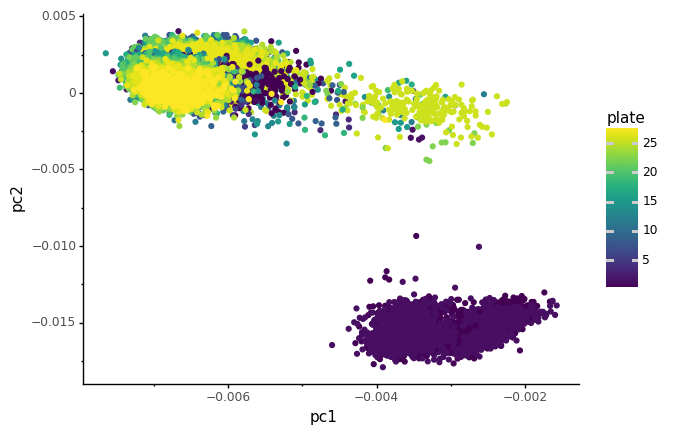

<ggplot: (8775109655785)>


In [16]:
print(
    ggplot(df, aes(x = 'pc1', y = 'pc2', colour = 'plate')) +
      theme_classic() +
      geom_point()
)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


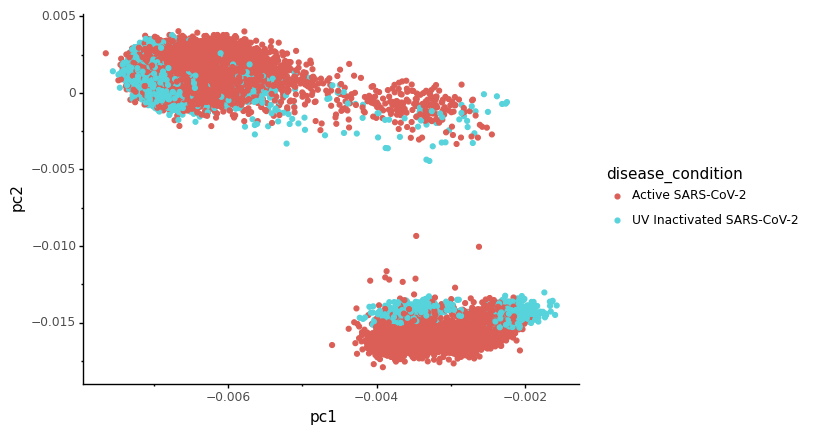

<ggplot: (8775109363421)>


In [17]:
print(
    ggplot(df, aes(x = 'pc1', y = 'pc2', colour = 'disease_condition')) +
      theme_classic() +
      geom_point()
)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


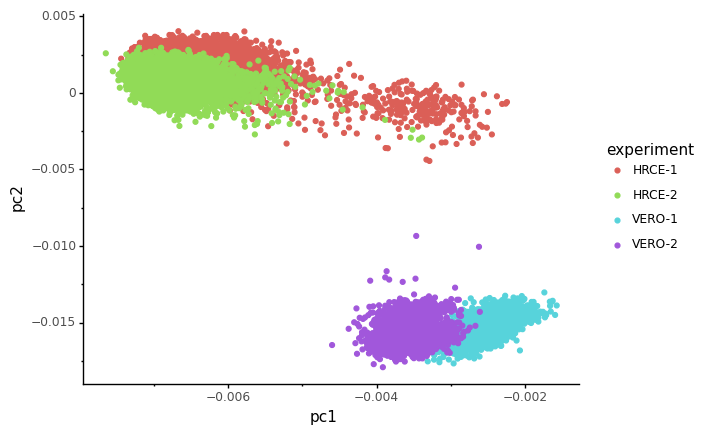

<ggplot: (8775109275817)>


In [18]:
print(
    ggplot(df, aes(x = 'pc1', y = 'pc2', colour = 'experiment')) +
      theme_classic() +
      geom_point()
)

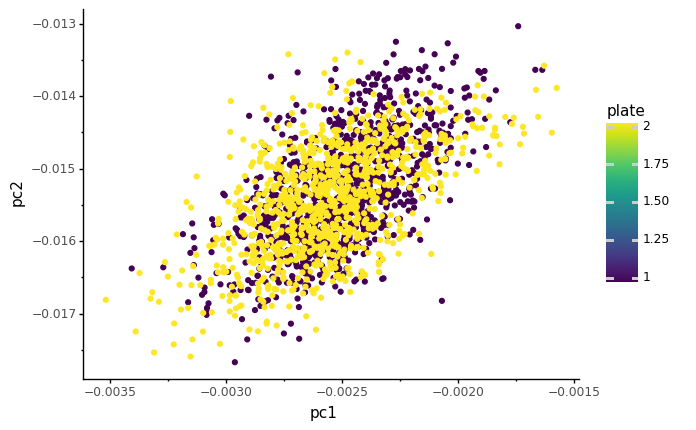

<ggplot: (8775109265873)>


In [19]:
print(
    ggplot(df[df.experiment == 'VERO-1'], aes(x = 'pc1', y = 'pc2', colour = 'plate')) +
      theme_classic() +
      geom_point()
)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


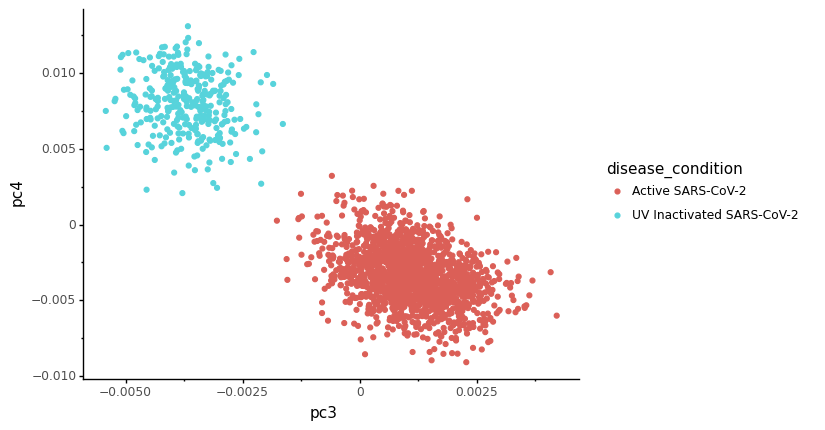

<ggplot: (8775109463949)>


In [20]:
print(
    ggplot(df[df.experiment == 'VERO-1'], aes(x = 'pc3', y = 'pc4', colour = 'disease_condition')) +
      theme_classic() +
      geom_point()
)

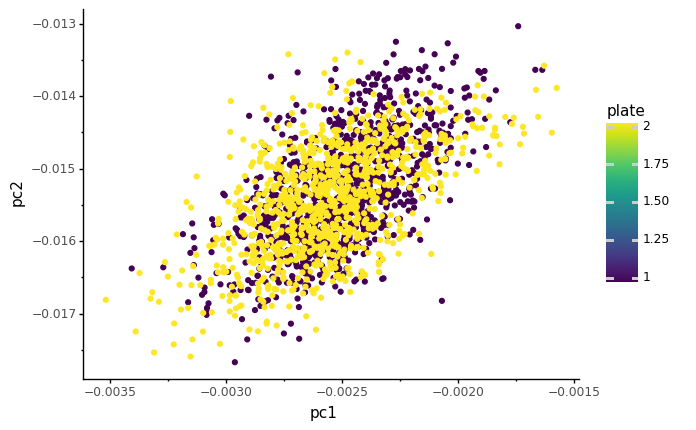

<ggplot: (8775109735249)>


In [21]:
print(
    ggplot(df[df.experiment == 'VERO-1'], aes(x = 'pc1', y = 'pc2', colour = 'plate')) +
      theme_classic() +
      geom_point()
)

In [22]:
print(df[df.experiment == 'VERO-1'].plate.value_counts())

2    984
1    984
Name: plate, dtype: int64


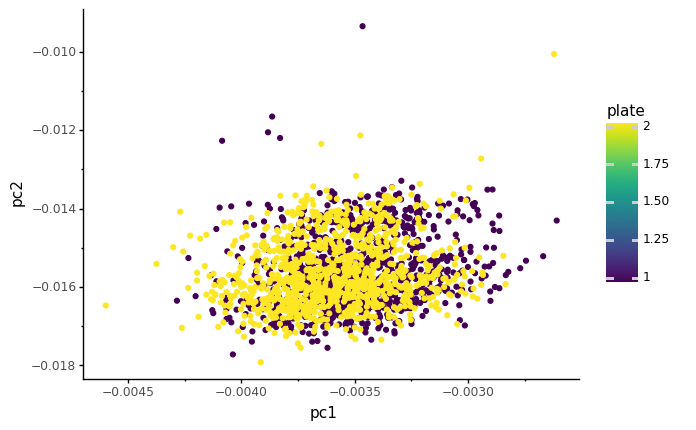

<ggplot: (8775109365765)>


In [23]:
print(
    ggplot(df[df.experiment == 'VERO-2'], aes(x = 'pc1', y = 'pc2', colour = 'plate')) +
      theme_classic() +
      geom_point()
)

In [24]:
features

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_984,feature_985,feature_986,feature_987,feature_988,feature_989,feature_990,feature_991,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999,feature_1000,feature_1001,feature_1002,feature_1003,feature_1004,feature_1005,feature_1006,feature_1007,feature_1008,feature_1009,feature_1010,feature_1011,feature_1012,feature_1013,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
0,2.194816,-0.105292,-0.046181,-0.161973,-1.006325,0.568540,0.572074,0.035659,0.007511,0.164367,-2.247998,-0.181741,-0.423900,0.698232,-0.401199,-1.122412,-0.373637,-0.046863,0.116290,0.409544,-0.888965,-0.122240,0.288801,0.292379,-2.149139,0.447995,0.164520,-0.835982,0.035967,0.887286,0.706116,-0.390038,-1.329361,0.856457,-1.736049,-0.364225,-1.600604,0.581005,-0.874511,1.330226,...,1.341386,-0.468223,0.538117,0.070580,0.605790,-0.144361,-0.146274,0.140962,-1.112346,0.598258,-0.624806,-0.311490,0.106665,0.227434,0.274042,0.127025,1.064981,0.652967,0.641275,-0.135642,0.797347,0.074700,-0.969595,-0.508196,-0.784785,0.586503,0.263047,0.175914,-1.763693,1.045773,0.661410,0.722917,-1.654883,-1.039532,-1.275908,-0.113406,-0.996582,0.107171,0.281750,-1.321678
1,2.095633,-0.218020,-0.127621,-0.149912,-0.780210,0.660563,0.759083,0.200471,0.130232,0.144276,-2.219276,-0.312596,0.001572,0.686735,-0.292512,-0.752496,-0.010625,0.041314,0.196330,0.227851,-0.811892,-0.065458,0.392610,0.317123,-2.095015,0.743022,-0.084748,-0.335948,-0.260214,0.704697,0.557673,-0.745947,-0.876843,0.929211,-1.637188,-0.196229,-1.520341,0.388264,-1.229970,0.937751,...,1.159489,-0.913465,0.356759,0.194295,0.610317,-0.129339,0.044339,-0.042947,-0.945177,0.145991,-0.330116,-0.293485,0.172474,0.509173,0.644552,0.279343,1.328315,0.450685,0.068520,-0.223828,0.974772,0.180896,-1.345791,-0.399947,-0.683695,0.714001,0.014900,0.172176,-1.542699,0.982410,0.900095,0.681125,-1.313322,-1.333047,-1.405456,0.115006,-0.670360,0.181035,0.014230,-1.406452
2,1.779929,0.032698,-0.462570,0.077970,-0.702946,0.595584,1.037175,0.178364,0.389227,0.248819,-1.940724,-0.027037,-0.387853,0.373134,-0.217204,-1.352820,-0.187606,-0.291927,0.091808,0.069726,-1.260857,0.065539,0.091628,0.131142,-2.043263,0.694833,-0.271105,-0.612495,-0.051544,0.827753,0.687539,-0.400177,-0.848895,0.706271,-1.640226,0.219508,-1.164511,0.328759,-0.941814,1.085459,...,1.109408,-0.305190,0.618345,-0.087457,0.593100,-0.234313,-0.091443,-0.007627,-0.645766,0.442182,-0.547041,-0.610101,0.047428,0.494137,0.534331,-0.051333,1.206033,0.551702,0.786685,-0.238686,0.697214,0.076854,-1.106121,-0.219094,-0.680953,0.371061,-0.188777,-0.078978,-1.352301,0.982278,0.576713,0.433239,-1.439914,-0.509420,-1.507544,-0.226118,-0.569021,-0.038540,-0.020967,-1.349082
3,2.033882,0.134098,0.321624,-0.194107,-0.874373,0.683397,0.753974,-0.107142,0.039776,-0.143926,-2.126543,-0.399251,-0.434634,0.900987,0.113495,-1.101074,-0.185616,0.324041,0.074304,0.190985,-1.017195,-0.240863,0.463857,0.108684,-1.311261,0.286679,-0.077689,-0.615285,0.183474,0.584526,1.039854,-0.277127,-1.197817,0.879276,-1.321653,-0.113458,-1.083410,0.367895,-1.067833,1.174180,...,0.890752,-0.630370,0.684931,0.063399,0.482260,0.199665,-0.252377,0.041392,-0.943781,0.529471,-0.202043,-0.755050,-0.075942,0.569397,0.747565,0.018093,0.830195,0.597094,0.481648,-0.244756,0.972515,0.490838,-0.938997,-0.298637,-0.572601,0.393464,0.137261,-0.303060,-1.802196,1.020054,0.513103,0.430219,-1.344728,-0.839880,-1.397942,0.003676,-0.995562,0.316649,-0.460665,-0.980651
4

In [25]:
pheno

,site_id,well_id,cell_type,experiment,plate,well,site,disease_condition
0,HRCE-1_1_AA08_1,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,1,UV Inactivated SARS-CoV-2
1,HRCE-1_1_AA08_2,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,2,UV Inactivated SARS-CoV-2
2,HRCE-1_1_AA08_3,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,3,UV Inactivated SARS-CoV-2
3,HRCE-1_1_AA08_4,HRCE-1_1_AA08,HRCE,HRCE-1,1,AA08,4,UV Inactivated SARS-CoV-2
4,HRCE-1_1_AA16_1,HRCE-1_1_AA16,HRCE,HRCE-1,1,AA16,1,UV Inactivated SARS-CoV-2
...,...,...,...,...,...,...,...,...
26307,VERO-2_2_Z43_4,VERO-2_2_Z43,VERO,VERO-2,2,Z43,4,Active SARS-CoV-2
26308,VERO-2_2_Z47_1,VERO-2_2_Z47,VERO,VERO-2,2,Z47,1,Active SARS-CoV-2
26309,VERO-2_2_Z47_2,VERO-2_2_Z47,VERO,VERO-2,2,Z47,2,Active SARS-CoV-2
26310,VERO-2_2_Z47_3,VERO-2_2_Z47,VERO,VERO-2,2,Z47,3,Active SARS-CoV-2


In [26]:
# technical variables: experiment, plate, site
# biological variable: disease_condition
# other variable of intereset: cell_type

#batch = [pd.factorize(pheno.experiment), pheno.plate.values, pheno.site.values]
batch = [pheno.plate.values, pheno.site.values]
batch

[array([1, 1, 1, ..., 2, 2, 2]), array([1, 2, 3, ..., 2, 3, 4])]

In [27]:
#features_bc = pycombat(features.to_numpy(), batch)

In [28]:
features.shape

(26312, 1024)

In [29]:
pheno.shape

(26312, 8)

In [30]:
type(features)

pandas.core.frame.DataFrame

In [31]:
from sklearn.model_selection import train_test_split
labels = pheno.disease_condition.to_numpy()
features_m = features.to_numpy()
print(labels)
print(features_m)
features_m.shape

['UV Inactivated SARS-CoV-2' 'UV Inactivated SARS-CoV-2'
 'UV Inactivated SARS-CoV-2' ... 'Active SARS-CoV-2' 'Active SARS-CoV-2'
 'Active SARS-CoV-2']
[[ 2.1948156  -0.10529242 -0.04618107 ...  0.10717131  0.28175047
  -1.3216785 ]
 [ 2.0956328  -0.21801966 -0.12762064 ...  0.18103497  0.01422971
  -1.4064523 ]
 [ 1.779929    0.03269813 -0.46257007 ... -0.03854018 -0.02096725
  -1.3490816 ]
 ...
 [ 0.7463089   0.22292234 -1.5681736  ...  1.6241531  -0.15015657
  -2.6339228 ]
 [ 0.51116973 -0.01147741 -1.5917935  ...  1.8866243  -0.95447075
  -2.867024  ]
 [ 0.70186126  0.43913198 -1.3747346  ...  2.1711388  -0.3461622
  -2.4070563 ]]


(26312, 1024)

In [32]:
#X_train, X_test, y_train, y_test = train_test_split(features_m, labels, test_size = 0.3, random_state=1334)

In [33]:
pheno['plate_well'] = (pheno.plate.to_string() + '_') + pheno.well
pheno.plate_well

0        0         1\n1         1\n2         1\n3      ...
1        0         1\n1         1\n2         1\n3      ...
2        0         1\n1         1\n2         1\n3      ...
3        0         1\n1         1\n2         1\n3      ...
4        0         1\n1         1\n2         1\n3      ...
                               ...                        
26307    0         1\n1         1\n2         1\n3      ...
26308    0         1\n1         1\n2         1\n3      ...
26309    0         1\n1         1\n2         1\n3      ...
26310    0         1\n1         1\n2         1\n3      ...
26311    0         1\n1         1\n2         1\n3      ...
Name: plate_well, Length: 26312, dtype: object

In [34]:
plate_well = pheno.plate_well.to_numpy()
random.shuffle(plate_well)


In [39]:

plate_well_train = plate_well[:18418]
plate_well_test = plate_well[18418:]

In [38]:
float(plate_well.shape[0]) * 0.7

18418.399999999998

In [41]:
idx_train = pheno['plate_well'].isin(plate_well_train)
idx_test = pheno['plate_well'].isin(plate_well_test)

In [42]:
pheno_train = pheno[idx_train]
pheno_test = pheno[idx_test]

features_train = features[idx_train]
features_test = features[idx_test]

In [53]:
X_train = features_train.to_numpy()
y_train, class_names = pd.factorize(pheno_train['disease_condition'])
X_test = features_test.to_numpy()
y_test, class_names = pd.factorize(pheno_test['disease_condition'])

In [54]:
X_train

array([[ 2.1948156 , -0.10529242, -0.04618107, ...,  0.10717131,
         0.28175047, -1.3216785 ],
       [ 2.0956328 , -0.21801966, -0.12762064, ...,  0.18103497,
         0.01422971, -1.4064523 ],
       [ 1.779929  ,  0.03269813, -0.46257007, ..., -0.03854018,
        -0.02096725, -1.3490816 ],
       ...,
       [ 0.7463089 ,  0.22292234, -1.5681736 , ...,  1.6241531 ,
        -0.15015657, -2.6339228 ],
       [ 0.51116973, -0.01147741, -1.5917935 , ...,  1.8866243 ,
        -0.95447075, -2.867024  ],
       [ 0.70186126,  0.43913198, -1.3747346 , ...,  2.1711388 ,
        -0.3461622 , -2.4070563 ]])

In [55]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [56]:
class_names

Index(['UV Inactivated SARS-CoV-2', 'Active SARS-CoV-2'], dtype='object')